### <font style="color:blue">Project 2: Kaggle Competition - Classification</font>

#### Maximum Points: 100

<div>
    <table>
        <tr><td><h3>Sr. no.</h3></td> <td><h3>Section</h3></td> <td><h3>Points</h3></td> </tr>
        <tr><td><h3>1</h3></td> <td><h3>Data Loader</h3></td> <td><h3>10</h3></td> </tr>
        <tr><td><h3>2</h3></td> <td><h3>Configuration</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>3</h3></td> <td><h3>Evaluation Metric</h3></td> <td><h3>10</h3></td> </tr>
        <tr><td><h3>4</h3></td> <td><h3>Train and Validation</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>5</h3></td> <td><h3>Model</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>6</h3></td> <td><h3>Utils</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>7</h3></td> <td><h3>Experiment</h3></td><td><h3>5</h3></td> </tr>
        <tr><td><h3>8</h3></td> <td><h3>TensorBoard Dev Scalars Log Link</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>9</h3></td> <td><h3>Kaggle Profile Link</h3></td> <td><h3>50</h3></td> </tr>
    </table>
</div>


## Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt  # one of the best graphics library for python
plt.style.use('ggplot')

In [2]:
import os
import random

import pandas as pd
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import shutil

import torch
import torchvision
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torchvision import datasets, transforms, models

import time
from tqdm import tqdm

from typing import Iterable
import itertools

from dataclasses import dataclass
from sklearn.metrics import confusion_matrix
import seaborn as sns


In [3]:

from torch.utils.tensorboard import SummaryWriter
# Define your custom log directory
log_dir = 'TFlearning_logs'

# Initialize the SummaryWriter with your log_dir
writer = SummaryWriter(log_dir=log_dir)

## <font style="color:green">1. Data Loader [10 Points]</font>

In this section, you have to write a class or methods, which will be used to get training and validation data loader.

You need to write a custom dataset class to load data.

**Note; There is   no separate validation data. , You will thus have to create your own validation set, by dividing the train data into train and validation data. Usually, we do 80:20 ratio for train and validation, respectively.**


For example:

```python
class KenyanFood13Dataset(Dataset):
    """
    
    """
    
    def __init__(self, *args):
    ....
    ...
    
    def __getitem__(self, idx):
    ...
    ...
    

```


```python
def get_data(args1, *args):
    ....
    ....
    return train_loader, test_loader
```

In [4]:
class KenyanFood13Dataset(Dataset):
    """
    Custom Dataset for loading images and labels for the KenyanFood13 challenge.
    This class reads a CSV file with columns 'id' and 'class', and loads images stored as '<id>.jpg'
    in the specified image root directory. It also supports optional image resizing and transformations.
    The train flag is used to split the full dataset into 80% training and 20% validation.
    """
    
    def __init__(self, csv_file, image_root, train=True, image_shape=None, transform=None):
        """
        Initialization method.
        
        Parameters:
        
        csv_file (str): Path to the CSV file containing image ids and class labels.
        
        image_root (str): Directory where image files are stored. Images are expected to be named as '<id>.jpg'.
        
        train (bool): If True, returns 80% of the data for training; if False, returns 20% for validation.
        
        image_shape (int or tuple or list): [optional] If provided, image will be resized to the given shape.
                                            If an integer is provided, images are resized to (image_shape, image_shape).
                                            If a tuple/list is provided with one value, it is converted to square dimensions;
                                            otherwise, the tuple is used as is.
                                            
        transform (callable): Transformation function to be applied on the PIL image.
        """
        # Read the CSV file containing the image ids and their class labels
        self.data = pd.read_csv(csv_file)
        self.image_root = image_root
        self.train = train
        self.transform = transform
        
        # Process image_shape parameter
        if image_shape is not None:
            if isinstance(image_shape, int):
                self.image_shape = (image_shape, image_shape)
            elif isinstance(image_shape, (tuple, list)):
                assert len(image_shape) in [1, 2], 'Invalid image_shape tuple/list size'
                self.image_shape = (image_shape[0], image_shape[0]) if len(image_shape) == 1 else image_shape
            else:
                raise NotImplementedError("image_shape must be an int, tuple, or list")
        else:
            self.image_shape = None
        
        # Create a mapping from class name to integer label
        self.classes = sorted(self.data['class'].unique())
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
        
        # Build the list of samples (each sample is a tuple of image path and numeric label)
        full_samples = []
        for _, row in self.data.iterrows():
            img_id = row['id']
            label_str = row['class']
            label = self.class_to_idx[label_str]
            img_path = os.path.join(self.image_root, f"{img_id}.jpg")
            full_samples.append((img_path, label))
        
        # Shuffle the full sample list with a fixed seed for reproducibility and split into train/validation.
        random.seed(42)
        random.shuffle(full_samples)
        n_train = int(0.8 * len(full_samples))
        if self.train:
            self.samples = full_samples[:n_train]
        else:
            self.samples = full_samples[n_train:]
    
    def __len__(self):
        """
        Returns:
            int: Total number of samples in the dataset.
        """
        return len(self.samples)
    
    def __getitem__(self, idx):
        """
        For the given index, returns the processed image and its label.
        
        Parameters:
            idx (int): Index of the sample to retrieve.
            
        Returns:
            image: Processed image.
            target (int): Numeric label for the image.
        """
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert("RGB")
        
        # Resize image if image_shape is specified
        if self.image_shape is not None:
            image = TF.resize(image, self.image_shape)
            
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label
    
    def class_name(self, label):
        """
        Gets the class name corresponding to a numeric label.
        
        Parameters:
            label (int): Numeric label.
        
        Returns:
            str: Class name.
        """
        return self.classes[label]
    
    

In [5]:
def split_and_copy():
    # Read the train.csv file
    csv_file_path = 'train.csv'
    df = pd.read_csv(csv_file_path)

    # Define directories for training and validation datasets
    train_dir = 'training'
    val_dir = 'validation'

    # Create directories for training and validation datasets, and subdirectories for each class
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)

    classes = df['class'].unique()
    for cls in classes:
        os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
        os.makedirs(os.path.join(val_dir, cls), exist_ok=True)

    # Split the data into training and validation sets (80:20 ratio)
    train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['class'], random_state=42)

    # Function to copy images to their respective directories
    def copy_images(df, src_dir, dest_dir):
        for _, row in df.iterrows():
            img_id = row['id']
            img_class = row['class']
            dest_path = os.path.join(dest_dir, img_class, f'{img_id}.jpg')
            src_path = os.path.join(src_dir, f'{img_id}.jpg')
            if os.path.exists(src_path):
                shutil.copy(src_path, dest_path)

    # Source directory containing the images
    src_dir = 'images/images'

    # Copy images to training and validation directories
    copy_images(train_df, src_dir, train_dir)
    copy_images(val_df, src_dir, val_dir)

    print('Training and validation datasets split and images copied successfully.')

# Check if training and validation folders exist;
# if they exist, skip the steps, otherwise run the corresponding function.
if os.path.exists('training') and os.path.exists('validation'):
    print("Folders exist, skipping data split and copy step.")
else:
    split_and_copy()

Folders exist, skipping data split and copy step.


In [6]:

train_data = datasets.ImageFolder("training")
validation_data = datasets.ImageFolder("validation")
print(train_data.class_to_idx)

{'bhaji': 0, 'chapati': 1, 'githeri': 2, 'kachumbari': 3, 'kukuchoma': 4, 'mandazi': 5, 'masalachips': 6, 'matoke': 7, 'mukimo': 8, 'nyamachoma': 9, 'pilau': 10, 'sukumawiki': 11, 'ugali': 12}


In [ ]:
def image_preprocess_transforms():
    
    preprocess = transforms.Compose([
        # transforms.Resize(256),
        # transforms.CenterCrop(224),
        transforms.Resize(240),
        transforms.CenterCrop(240),
        transforms.ToTensor()
        ])
    
    return preprocess

def image_common_transforms(mean, std):
    preprocess = image_preprocess_transforms()
    
    common_transforms = transforms.Compose([
        preprocess,
        transforms.Normalize(mean, std)
    ])
    
    return common_transforms

def get_mean_std():
    
    mean = [0.485, 0.456, 0.406] 
    std = [0.229, 0.224, 0.225]
    
    return mean, std

def data_loader(data_root, transform, batch_size=16, shuffle=False, num_workers=2):
    dataset = datasets.ImageFolder(root=data_root, transform=transform)
    
    loader = torch.utils.data.DataLoader(dataset, 
                                         batch_size=batch_size,
                                         num_workers=num_workers,
                                         shuffle=shuffle)
    
    return loader

def data_augmentation_preprocess(mean, std):
    """
    Defines the data augmentation and preprocessing pipeline.
  
    Args:
        mean (list): Mean values for normalization.
        std (list): Standard deviation values for normalization.

    Returns:
        torchvision.transforms.Compose: The composed transformations.
    """
    return transforms.Compose([
        # transforms.Resize((256, 256)),
        transforms.Resize((240, 240)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),  
        transforms.RandomRotation(30),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        transforms.RandomPerspective(distortion_scale=0.4),
        # transforms.RandomResizedCrop((224, 224), scale=(0.8, 1.0)),
        transforms.RandomResizedCrop((240, 240), scale=(0.8, 1.0)),
        transforms.RandomGrayscale(p=0.1),
        transforms.ToTensor(),
        transforms.RandomErasing(p=0.1, scale=(0.02, 0.1), ratio=(0.3, 3.3)), 
        transforms.Normalize(mean=mean, std=std)
    ])


def get_data(batch_size, data_root, num_workers=4, data_augmentation=True):
    
    train_data_path = os.path.join(data_root, 'training')
       
    # mean, std = get_mean_std(data_root=train_data_path, num_workers=num_workers)
    mean, std = get_mean_std()
    
    common_transforms = image_common_transforms(mean, std)
        
   
    # if data_augmentation is true 
    # data augmentation implementation
    if data_augmentation:    
        train_transforms = data_augmentation_preprocess(mean, std)
    # else do common transforms
    else:
        train_transforms = common_transforms
        
        
    # train dataloader
    
    train_loader = data_loader(train_data_path, 
                               train_transforms, 
                               batch_size=batch_size, 
                               shuffle=True, 
                               num_workers=num_workers)
    
    # test dataloader
    
    test_data_path = os.path.join(data_root, 'validation')
    
    test_loader = data_loader(test_data_path, 
                              common_transforms, # use common transforms for validation
                              batch_size=batch_size, 
                              shuffle=False, 
                              num_workers=num_workers)
    
    # Print data length before and after augmentation
    print(f"Training data length: {len(train_loader.dataset)}")
    print(f"Validation data length: {len(test_loader.dataset)}")

    # Get a batch from your train_loader (or val_loader)
    dataiter = iter(train_loader) # or iter(val_loader)
    images, labels = next(dataiter)

    # Convert images to numpy and remove normalization (if you normalized) for visualization
    def imshow(img):
        img = img / 2 + 0.5  # If you normalized with mean=0.5, std=0.5, adjust accordingly
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.show()

    # Show images
    print("Visualizing data samples...")
    imshow(torchvision.utils.make_grid(images))
    # Print labels
    print(' '.join('%5s' % food_classes[labels[j]] for j in range(batch_size)))
    

    return train_loader, test_loader
    

## <font style="color:green">2. Configuration [5 Points]</font>

**Define your configuration here.**

For example:


```python
@dataclass
class TrainingConfiguration:
    '''
    Describes configuration of the training process
    '''
    batch_size: int = 10 
    epochs_count: int = 50  
    init_learning_rate: float = 0.1  # initial learning rate for lr scheduler
    log_interval: int = 5  
    test_interval: int = 1  
    data_root: str = "/kaggle/input/opencv-pytorch-project-2-classification-round-3" 
    num_workers: int = 2  
    device: str = 'cuda'  
    
```

In [8]:
@dataclass
class SystemConfiguration:
    '''
    Describes the common system setting needed for reproducible training
    '''
    seed: int = 21  # seed number to set the state of all random number generators
    cudnn_benchmark_enabled: bool = True  # enable CuDNN benchmark for the sake of performance
    cudnn_deterministic: bool = True  # make cudnn deterministic (reproducible training)

In [9]:
@dataclass
class TrainingConfiguration:
    '''
    Describes configuration of the training process
    '''
    batch_size: int = 16  # amount of data to pass through the network at each forward-backward iteration  
    epochs_count: int = 250  # number of times the whole dataset will be passed through the network 
    init_learning_rate: float = 0.0001  # initial learning rate for lr scheduler
    decay_rate: float = 0.1  # rate to decay learning rate
    log_interval: int = 10  # how many batches to wait before logging training status  
    test_interval: int = 1  
    data_root: str = './'
    csv_file: str = './train.csv'
    num_workers: int = 2  # number of concurrent processes using to prepare data  
    device: str = 'cuda'  
    lr_scheduler_patience: int = 5     # Patience (in epochs) for ReduceLROnPlateau scheduler
    lr_scheduler_factor: float = 0.3   # LR reduction factor when plateauing
    early_stopping_patience: int = 15  # Patience (in epochs) for early stopping
    



In [10]:
def setup_system(system_config: SystemConfiguration) -> None:
    torch.manual_seed(system_config.seed)
    if torch.cuda.is_available():
        torch.backends.cudnn_benchmark_enabled = system_config.cudnn_benchmark_enabled
        torch.backends.cudnn.deterministic = system_config.cudnn_deterministic

In [11]:
# food_classes = ['Ugali', 'Chapati', 'Mukimo', 'Matoke', 'Kachumbari', 'Sukuma Wiki', 'Nyama Choma', 'Githeri', 'Mandazi', 'Pilau', 'Kebab', 'Samaki', 'Wali']
dataset = KenyanFood13Dataset(TrainingConfiguration.csv_file, TrainingConfiguration.data_root, train=False, image_shape=224)
food_classes = dataset.classes
food_classes

['bhaji',
 'chapati',
 'githeri',
 'kachumbari',
 'kukuchoma',
 'mandazi',
 'masalachips',
 'matoke',
 'mukimo',
 'nyamachoma',
 'pilau',
 'sukumawiki',
 'ugali']

## <font style="color:green">3. Evaluation Metric [10 Points]</font>

**Define methods or classes that will be used in model evaluation. For example, accuracy, f1-score etc.**

In [12]:
def prediction(model, device, batch_input, max_prob=True):
    """
    get prediction for batch inputs
    """
    
    # send model to cpu/cuda according to your system configuration
    model.to(device)
    
    # it is important to do model.eval() before prediction
    model.eval()

    data = batch_input.to(device)

    output = model(data)

    # get probability score using softmax
    prob = F.softmax(output, dim=1)
    
    if max_prob:
        # get the max probability
        pred_prob = prob.data.max(dim=1)[0]
    else:
        pred_prob = prob.data
    
    # get the index of the max probability
    pred_index = prob.data.max(dim=1)[1]
    
    return pred_index.cpu().numpy(), pred_prob.cpu().numpy()

In [13]:
def get_target_and_prob(model, dataloader, device):
    """
    get targets and prediction probabilities
    """
    
    pred_prob = []
    targets = []
    
    for _, (data, target) in enumerate(dataloader):
        
        _, prob = prediction(model, device, data, max_prob=False)
        
        pred_prob.append(prob)
        
        target = target.numpy()
        targets.append(target)
        
    targets = np.concatenate(targets)
    targets = targets.astype(int)
    pred_prob = np.concatenate(pred_prob, axis=0)
    
    return targets, pred_prob


def plot_confusion_matrix(model, data_root, mean, std, batch_size=32):
    # Set device and move model
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    model.eval()
    
    # Create dataset and dataloader with common transforms
    test_dataset = datasets.ImageFolder(
        root=data_root,
        transform=image_common_transforms(mean, std)
    )
    dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    
    all_preds = []
    all_targets = []
    
    # Disable gradient calculation for inference
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    
    # Compute confusion matrix
    cm = confusion_matrix(all_targets, all_preds)
    
    # Plot confusion matrix using seaborn heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=test_dataset.classes,
                yticklabels=test_dataset.classes)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

## <font style="color:green">4. Train and Validation [5 Points]</font>


**Write the methods or classes to be used for training and validation.**

In [14]:
def train(
    train_config: TrainingConfiguration, model: nn.Module, optimizer: torch.optim.Optimizer,
    train_loader: torch.utils.data.DataLoader, epoch_idx: int, tb_writer: SummaryWriter
) -> None:
    
    # change model in training mode
    model.train()
    
    # to get batch loss
    batch_loss = np.array([])
    
    # to get batch accuracy
    batch_acc = np.array([])
        
    for batch_idx, (data, target) in enumerate(train_loader):
        
        # clone target
        indx_target = target.clone()
        # send data to device (it is mandatory if GPU has to be used)
        data = data.to(train_config.device)
        # send target to device
        target = target.to(train_config.device)

        # reset parameters gradient to zero
        optimizer.zero_grad()
        
        # forward pass to the model
        output = model(data)
        
        # cross entropy loss
        loss = F.cross_entropy(output, target)
        
        # find gradients w.r.t training parameters
        loss.backward()
        # Update parameters using gradients
        optimizer.step()
        
        batch_loss = np.append(batch_loss, [loss.item()])
        
        # get probability score using softmax
        prob = F.softmax(output, dim=1)
            
        # get the index of the max probability
        pred = prob.data.max(dim=1)[1]  
                        
        # correct prediction
        correct = pred.cpu().eq(indx_target).sum()
            
        # accuracy
        acc = float(correct) / float(len(data))
        
        batch_acc = np.append(batch_acc, [acc])

        if batch_idx % train_config.log_interval == 0 and batch_idx > 0:
            
            total_batch = epoch_idx * len(train_loader.dataset)/train_config.batch_size + batch_idx
            tb_writer.add_scalar('Loss/train-batch', loss.item(), total_batch)
            tb_writer.add_scalar('Accuracy/train-batch', acc, total_batch)
            
    epoch_loss = batch_loss.mean()
    epoch_acc = batch_acc.mean()

    # Log epoch loss and accuracy
    tb_writer.add_scalar('Loss/Train', epoch_loss, epoch_idx)
    tb_writer.add_scalar('Accuracy/Train', epoch_acc, epoch_idx)

    # Print epoch loss and accuracy
    print(
        "\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
            epoch_loss, int(epoch_acc * len(train_loader.dataset)), len(train_loader.dataset), epoch_acc * 100
        )
    )   
    
    return epoch_loss, epoch_acc

In [15]:
def validate(
    train_config: TrainingConfiguration,
    model: nn.Module,
    test_loader: torch.utils.data.DataLoader,
) -> float:
    model.eval()
    test_loss = 0
    count_correct_predictions = 0
    # Iterate over test_loader with a tqdm progress bar.
    for data, target in tqdm(test_loader, desc="Validation", leave=False):
        indx_target = target.clone()
        data = data.to(train_config.device)
        target = target.to(train_config.device)
        # print("Data device:", data.device)
        # print("Target device:", target.device)
        
        with torch.no_grad():
            output = model(data)
        
        # Accumulate loss for each mini batch
        test_loss += F.cross_entropy(output, target).item()
        
        # Get predictions from probabilities
        prob = F.softmax(output, dim=1)
        pred = prob.data.max(dim=1)[1]
        
        count_correct_predictions += pred.cpu().eq(indx_target).sum().item()

    # Average loss over the number of mini-batches
    test_loss = test_loss / len(test_loader)
    
    # Compute accuracy over the entire dataset
    accuracy = 100. * count_correct_predictions / len(test_loader.dataset)
    
    print(
        "\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
            test_loss, count_correct_predictions, len(test_loader.dataset), accuracy
        )
    )
    return test_loss, accuracy / 100.0

In [16]:
def save_model(model, device, model_dir='models', model_file_name='final_kenyaFood_classifier.pt'):
    
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

    model_path = os.path.join(model_dir, model_file_name)

    # make sure you transfer the model to cpu. 
    if device == 'cuda':
        model.to('cpu')

    # save the state_dict
    torch.save(model.state_dict(), model_path)
    
    if device == 'cuda':
        model.to('cuda')
    
    return model_path                                 

def load_model(model, model_dir='models', model_file_name='final_kenyaFood_classifier.pt'):
    model_path = os.path.join(model_dir, model_file_name)

    # loading the model and getting model parameters by using load_state_dict
    model.load_state_dict(torch.load(model_path))
    
    return model                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

## <font style="color:green">5. Model [5 Points]</font>

**Define your model in this section.**

**You are allowed to use any pre-trained model.**

In [17]:
class CustomResNet(nn.Module):
    def __init__(self, num_classes=13, dropout_prob=0.5):
        super(CustomResNet, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        self.resnet.fc = nn.Sequential(
            nn.Linear(self.resnet.fc.in_features, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.resnet(x)

In [18]:
from efficientnet_pytorch import EfficientNet

class CustomEfficientNet(nn.Module):
    def __init__(self, num_classes=13, dropout_prob=0.5):
        super(CustomEfficientNet, self).__init__()
        # self.efficientnet = EfficientNet.from_pretrained('efficientnet-b0')
        self.efficientnet = EfficientNet.from_pretrained('efficientnet-b1')
        self.efficientnet._fc = nn.Sequential(
            nn.Linear(self.efficientnet._fc.in_features, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.7),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.efficientnet(x)

## <font style="color:green">6. Utils [5 Points]</font>

**Define those methods or classes, which have  not been covered in the above sections.**

In [19]:
def add_pr_curves_to_tensorboard(model, dataloader, device, tb_writer, epoch, num_classes=3):
    """
    Add precession and recall curve to tensorboard.
    """
    
    targets, pred_prob = get_target_and_prob(model, dataloader, device)
    
    for cls_idx in range(num_classes):
        binary_target = targets == cls_idx
        true_prediction_prob = pred_prob[:, cls_idx]
        
        tb_writer.add_pr_curve(food_classes[cls_idx], 
                               binary_target, 
                               true_prediction_prob, 
                               global_step=epoch)
        
    return

def add_wrong_prediction_to_tensorboard(model, dataloader, device, tb_writer, 
                                        epoch, tag='Wrong_Predections', max_images='all'):
    """
    Add wrong predicted images to tensorboard.
    """
    #number of images in one row
    num_images_per_row = 8
    im_scale = 3
    
    plot_images = []
    wrong_labels = []
    pred_prob = []
    right_label = []
    
    mean, std = get_mean_std()
    
    for _, (data, target) in enumerate(dataloader):
        
        
        images = data.numpy()
        pred, prob = prediction(model, device, data)
        target = target.numpy()
        indices = pred.astype(int) != target.astype(int)
        
        plot_images.append(images[indices])
        wrong_labels.append(pred[indices])
        pred_prob.append(prob[indices])
        right_label.append(target[indices])
        
    plot_images = np.concatenate(plot_images, axis=0).squeeze()
    plot_images = (np.moveaxis(plot_images, 1, -1) * std) + mean
    wrong_labels = np.concatenate(wrong_labels)
    wrong_labels = wrong_labels.astype(int)
    right_label = np.concatenate(right_label)
    right_label = right_label.astype(int)
    pred_prob = np.concatenate(pred_prob)
    
    
    if max_images == 'all':
        num_images = len(images)
    else:
        num_images = min(len(plot_images), max_images)
        
    fig_width = num_images_per_row * im_scale
    
    if num_images % num_images_per_row == 0:
        num_row = num_images/num_images_per_row
    else:
        num_row = int(num_images/num_images_per_row) + 1
        
    fig_height = num_row * im_scale
        
    plt.style.use('default')
    plt.rcParams["figure.figsize"] = (fig_width, fig_height)
    fig = plt.figure()
    
    for i in range(num_images):
        plt.subplot(num_row, num_images_per_row, i+1, xticks=[], yticks=[])
        plt.imshow((plot_images[i]*255).astype(np.uint8))
        plt.gca().set_title('{0}({1:.2}), {2}'.format(food_classes[wrong_labels[i]], 
                                                          pred_prob[i], 
                                                          food_classes[right_label[i]]))
        
    tb_writer.add_figure(tag, fig, global_step=epoch)
    
    return

    
def add_model_weights_as_histogram(model, tb_writer, epoch):
    for name, param in model.named_parameters():
        tb_writer.add_histogram(name.replace('.', '/'), param.data.cpu().abs(), epoch)
    return


def add_network_graph_tensorboard(model, inputs, tb_writer):
    tb_writer.add_graph(model, inputs)
    return

In [20]:
def main(model, optimizer, tb_writer, scheduler=None, early_stopping=None, 
         system_configuration=SystemConfiguration(), 
         training_configuration=TrainingConfiguration(), 
         data_augmentation=True):
    
    print("Step 1: Setting up system configuration...")
    setup_system(system_configuration)

    print("Step 2: Initializing training parameters (batch size, num_workers, epochs)...")
    batch_size_to_set = training_configuration.batch_size
    num_workers_to_set = training_configuration.num_workers
    epoch_num_to_set = training_configuration.epochs_count

    print("Step 3: Selecting device...")
    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
        batch_size_to_set = 16
        num_workers_to_set = 4
    print("  Device selected:", device)

    # Move model to the selected device
    model.to(device)
    print("Model device:", next(model.parameters()).device)

    print("Step 4: Creating data loaders...")
    train_loader, test_loader = get_data(
        batch_size=batch_size_to_set,
        data_root=training_configuration.data_root,
        num_workers=num_workers_to_set,
        data_augmentation=data_augmentation
    )
    print("Data loaders created.")
    
    print("Step 5: Updating training configuration with system-adjusted parameters...")
    training_configuration = TrainingConfiguration(
        device=device,
        batch_size=batch_size_to_set,
        num_workers=num_workers_to_set
    )
        
    print("Step 6: Sending model to device...")
    model.to(training_configuration.device)
    print("Model device after update:", next(model.parameters()).device)

    # Add network graph with inputs info
    images, labels = next(iter(test_loader))
    images = images.to(training_configuration.device)
    tb_writer.add_graph(model, images)

    best_loss = float('inf')
    
    # Arrays to track epoch train/test loss and accuracy
    epoch_train_loss = np.array([])
    epoch_test_loss = np.array([])
    epoch_train_acc = np.array([])
    epoch_test_acc = np.array([])
    
    print("Step 7: Performing initial validation...")
    init_val_loss, init_val_accuracy = validate(training_configuration, model, test_loader)
    print("Initial Test Loss: {:.6f}, Initial Test Accuracy: {:.3f}%".format(
        init_val_loss, init_val_accuracy * 100))
    
    t_begin = time.time()
    print("Step 8: Starting training loop for {} epochs...".format(training_configuration.epochs_count))
    for epoch in range(training_configuration.epochs_count):
        print("\nEpoch [{}/{}] Start".format(epoch + 1, training_configuration.epochs_count))
        
        # Train
        train_loss, train_acc = train(training_configuration, model, 
                                      optimizer, train_loader, epoch, writer)
        epoch_train_loss = np.append(epoch_train_loss, train_loss)
        epoch_train_acc = np.append(epoch_train_acc, train_acc)
        
        # Log training loss and accuracy
        tb_writer.add_scalar('Loss/Train', train_loss, epoch)
        tb_writer.add_scalar('Accuracy/Train', train_acc, epoch)
        
        elapsed_time = time.time() - t_begin
        speed_epoch = elapsed_time / (epoch + 1)
        speed_batch = speed_epoch / len(train_loader)
        eta = speed_epoch * training_configuration.epochs_count - elapsed_time
        print("Elapsed {:.2f}s, {:.2f} s/epoch, {:.2f} s/batch, ETA {:.2f}s".format(
            elapsed_time, speed_epoch, speed_batch, eta))

        # Log time metrics
        tb_writer.add_scalar('Time/elapsed_time', elapsed_time, epoch)
        tb_writer.add_scalar('Time/speed_epoch', speed_epoch, epoch)
        tb_writer.add_scalar('Time/speed_batch', speed_batch, epoch)
        tb_writer.add_scalar('Time/eta', eta, epoch)

        # Validate at set interval
        if epoch % training_configuration.test_interval == 0:
            print("Step 9: Running validation for epoch {}...".format(epoch + 1))
            current_loss, current_accuracy = validate(training_configuration, model, test_loader)
            epoch_test_loss = np.append(epoch_test_loss, current_loss)
            epoch_test_acc = np.append(epoch_test_acc, current_accuracy)
            
            # Log validation loss and accuracy
            tb_writer.add_scalar('Loss/Validation', current_loss, epoch)
            tb_writer.add_scalar('Accuracy/Validation', current_accuracy, epoch)
            
            # Log train and validation loss/accuracy together
            tb_writer.add_scalars('Loss/train-val', {'train': train_loss, 'validation': current_loss}, epoch)
            tb_writer.add_scalars('Accuracy/train-val', {'train': train_acc, 'validation': current_accuracy}, epoch)
            
            # Early stopping check using validation loss
            if epoch >= 20 and early_stopping is not None:
                early_stopping(current_loss, model)
                if early_stopping.early_stop:
                    print("Early stopping triggered")
                    break

            # Scheduler step/update; prefer validation loss for ReduceLROnPlateau
            if scheduler is not None:
                if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
                    scheduler.step(current_loss)
                    print("Bad Epochs: {}".format(scheduler.num_bad_epochs))
                    print("Last LR = {}".format(scheduler._last_lr))
                else:
                    scheduler.step()

            # Save the model if loss has improved
            if current_loss < best_loss:
                best_loss = current_loss
                print("Model Improved. Saving the Model...\n")
                save_model(model, device=training_configuration.device)
        
        # Log model weights as histograms
        for name, param in model.named_parameters():
            tb_writer.add_histogram(f'{name}/weights', param, epoch)
            if param.grad is not None:
                tb_writer.add_histogram(f'{name}/gradients', param.grad, epoch)
        
        # Add PR curves to TensorBoard
        add_pr_curves_to_tensorboard(model, test_loader, training_configuration.device, tb_writer, epoch, num_classes=13)
        
    print("\nStep 10: Training complete.")
    print("Total time: {:.2f}s, Best Loss: {:.3f}".format(time.time() - t_begin, best_loss), flush=True)
    return model, epoch_train_loss, epoch_train_acc, epoch_test_loss, epoch_test_acc



In [21]:
def plot_loss_accuracy(train_loss, val_loss, train_acc, val_acc, colors, 
                       loss_legend_loc='upper center', acc_legend_loc='upper left', 
                       fig_size=(20, 10), sub_plot1=(1, 2, 1), sub_plot2=(1, 2, 2)):
    
    plt.rcParams["figure.figsize"] = fig_size
    fig = plt.figure()
    
    plt.subplot(sub_plot1[0], sub_plot1[1], sub_plot1[2])
    
    for i in range(len(train_loss)):
        x_train = range(len(train_loss[i]))
        x_val = range(len(val_loss[i]))
        
        min_train_loss = train_loss[i].min()
        
        min_val_loss = val_loss[i].min()
        
        plt.plot(x_train, train_loss[i], linestyle='-', color='tab:{}'.format(colors[i]), 
                 label="TRAIN LOSS ({0:.4})".format(min_train_loss))
        plt.plot(x_val, val_loss[i], linestyle='--' , color='tab:{}'.format(colors[i]), 
                 label="VALID LOSS ({0:.4})".format(min_val_loss))
        
    plt.xlabel('epoch no.')
    plt.ylabel('loss')
    plt.legend(loc=loss_legend_loc)
    plt.title('Training and Validation Loss')
        
    plt.subplot(sub_plot2[0], sub_plot2[1], sub_plot2[2])
    
    for i in range(len(train_acc)):
        x_train = range(len(train_acc[i]))
        x_val = range(len(val_acc[i]))
        
        max_train_acc = train_acc[i].max() 
        
        max_val_acc = val_acc[i].max() 
        
        plt.plot(x_train, train_acc[i], linestyle='-', color='tab:{}'.format(colors[i]), 
                 label="TRAIN ACC ({0:.4})".format(max_train_acc))
        plt.plot(x_val, val_acc[i], linestyle='--' , color='tab:{}'.format(colors[i]), 
                 label="VALID ACC ({0:.4})".format(max_val_acc))
        
    plt.xlabel('epoch no.')
    plt.ylabel('accuracy')
    plt.legend(loc=acc_legend_loc)
    plt.title('Training and Validation Accuracy')
    
    fig.savefig('sample_loss_acc_plot.png')
    plt.show()
    
    return   

def get_sample_mistakes(model, data_root, mean, std, sample_count=15):
    # Device configuration
    if torch.cuda.is_available():
        device = "cuda"
        num_workers = 8
    else:
        device = "cpu"
        num_workers = 2

    model.eval()
    model.to(device)
    
    # Transformed dataset: used as model input
    test_dataset_trans = datasets.ImageFolder(root=data_root, 
                                               transform=image_common_transforms(mean, std))
    # Original dataset: used for visualization
    test_dataset = datasets.ImageFolder(root=data_root, 
                                         transform=image_preprocess_transforms())
    
    mistakes_imgs = []
    mistakes_targets = []
    mistakes_preds = []
    
    data_len = len(test_dataset)
    
    # Iterate over test dataset until we collect sample_count mistakes.
    for index in range(data_len):
        # Get transformed input and original image & target
        input_img, target = test_dataset_trans.__getitem__(index)
        original_img, _ = test_dataset.__getitem__(index)
        
        # Add batch dimension and send to device
        input_tensor = input_img.unsqueeze(0).to(device)
        
        # Get prediction using the provided prediction function.
        pred_class, prob = prediction(model, device, batch_input=input_tensor)
        
        # If the prediction is wrong, record this sample.
        if pred_class[0] != target:
            mistakes_imgs.append(original_img)
            mistakes_targets.append(target)
            mistakes_preds.append((pred_class[0], prob[0]))
        
        if len(mistakes_imgs) >= sample_count:
            break

    # Plot misclassified images
    plt.style.use('default')
    plt.rcParams["figure.figsize"] = (15, 9)
    fig = plt.figure()
    
    for i, target in enumerate(mistakes_targets):
        plt.subplot(3, 5, i+1)
        img = transforms.functional.to_pil_image(mistakes_imgs[i])
        predicted_class, probability = mistakes_preds[i]
        title = 'P: {0} ({1:.2f}), T: {2}'.format(test_dataset.classes[predicted_class], 
                                                     probability, 
                                                     test_dataset.classes[target])
        plt.imshow(img)
        plt.title(title)
        plt.axis("off")
    
    fig.savefig('sample_mistakes.png')
    plt.show()

    return

In [22]:
# Define early stopping class
class EarlyStopping:
    def __init__(self, patience=10, verbose=False, delta=0, checkpoint_path='checkpoint.pt'):
        """
        Args:
            patience (int): Number of epochs with no improvement after which training will be stopped.
            verbose (bool): If True, prints messages when the validation loss decreases.
            delta (float): Minimum change in the validation loss to qualify as an improvement.
            checkpoint_path (str): Path to save the best model.
        """
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.checkpoint_path = checkpoint_path
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model):
        score = -val_loss  # lower loss is better

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        """Saves model when validation loss decreases."""
        if self.verbose:
            print(f"Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model...")
        torch.save(model.state_dict(), self.checkpoint_path)
        self.val_loss_min = val_loss

## <font style="color:green">7. Experiment [5 Points]</font>

**Choose your optimizer and LR-scheduler and use the above methods and classes to train your model.**

In [23]:
# model = CustomResNet(num_classes=13, dropout_prob=0.5)
model = CustomEfficientNet(num_classes=13, dropout_prob=0.5)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
print(model)

train_config = TrainingConfiguration()

# optimizer (using Adam)
optimizer = optim.Adam(
    model.parameters(),
    lr=train_config.init_learning_rate,
    weight_decay=0.001

)

# Initialize early stopping
early_stopping = EarlyStopping(patience=train_config.early_stopping_patience, verbose=True)

# ReduceLROnPlateau scheduler to decay LR when validation stops improving
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,
                                           factor=train_config.lr_scheduler_factor,
                                           patience=train_config.lr_scheduler_patience,
                                           verbose=True,
                                           mode='min',
                                           min_lr=1e-7
                                           )

Loaded pretrained weights for efficientnet-b1
CustomEfficientNet(
  (efficientnet): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()


C:\Users\lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Step 1: Setting up system configuration...
Step 2: Initializing training parameters (batch size, num_workers, epochs)...
Step 3: Selecting device...
  Device selected: cuda
Model device: cuda:0
Step 4: Creating data loaders...
Training data length: 5228
Validation data length: 1308


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Visualizing data samples...


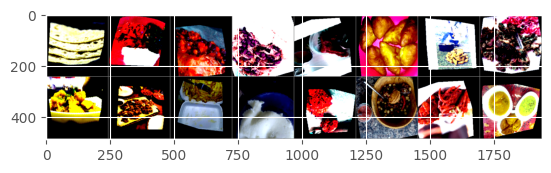

chapati ugali githeri ugali mandazi mandazi mandazi nyamachoma masalachips nyamachoma masalachips ugali bhaji githeri bhaji mandazi
Data loaders created.
Step 5: Updating training configuration with system-adjusted parameters...
Step 6: Sending model to device...
Model device after update: cuda:0
Step 7: Performing initial validation...



Test set: Average loss: 2.5757, Accuracy: 80/1308 (6%)

Initial Test Loss: 2.575745, Initial Test Accuracy: 6.116%
Step 8: Starting training loop for 250 epochs...

Epoch [1/250] Start

Train set: Average loss: 2.2389, Accuracy: 1482/5228 (28%)

Elapsed 87.88s, 87.88 s/epoch, 0.27 s/batch, ETA 21882.07s
Step 9: Running validation for epoch 1...



Test set: Average loss: 1.5813, Accuracy: 704/1308 (54%)

Bad Epochs: 0
Last LR = [0.0001]
Model Improved. Saving the Model...


Epoch [2/250] Start

Train set: Average loss: 1.7056, Accuracy: 2452/5228 (47%)

Elapsed 184.74s, 92.37 s/epoch, 0.28 s/batch, ETA 22907.20s
Step 9: Running validation for epoch 2...



Test set: Average loss: 1.2423, Accuracy: 815/1308 (62%)

Bad Epochs: 0
Last LR = [0.0001]
Model Improved. Saving the Model...


Epoch [3/250] Start

Train set: Average loss: 1.4840, Accuracy: 2827/5228 (54%)

Elapsed 281.73s, 93.91 s/epoch, 0.29 s/batch, ETA 23196.08s
Step 9: Running validation for epoch 3...



Test set: Average loss: 1.0521, Accuracy: 903/1308 (69%)

Bad Epochs: 0
Last LR = [0.0001]
Model Improved. Saving the Model...


Epoch [4/250] Start

Train set: Average loss: 1.3430, Accuracy: 3061/5228 (59%)

Elapsed 382.32s, 95.58 s/epoch, 0.29 s/batch, ETA 23512.81s
Step 9: Running validation for epoch 4...



Test set: Average loss: 0.9451, Accuracy: 930/1308 (71%)

Bad Epochs: 0
Last LR = [0.0001]
Model Improved. Saving the Model...


Epoch [5/250] Start

Train set: Average loss: 1.2330, Accuracy: 3266/5228 (62%)

Elapsed 483.27s, 96.65 s/epoch, 0.30 s/batch, ETA 23680.00s
Step 9: Running validation for epoch 5...



Test set: Average loss: 0.8674, Accuracy: 963/1308 (74%)

Bad Epochs: 0
Last LR = [0.0001]
Model Improved. Saving the Model...


Epoch [6/250] Start

Train set: Average loss: 1.1556, Accuracy: 3368/5228 (64%)

Elapsed 581.32s, 96.89 s/epoch, 0.30 s/batch, ETA 23640.30s
Step 9: Running validation for epoch 6...



Test set: Average loss: 0.8667, Accuracy: 940/1308 (72%)

Bad Epochs: 0
Last LR = [0.0001]
Model Improved. Saving the Model...


Epoch [7/250] Start

Train set: Average loss: 1.0686, Accuracy: 3531/5228 (68%)

Elapsed 679.39s, 97.06 s/epoch, 0.30 s/batch, ETA 23584.65s
Step 9: Running validation for epoch 7...



Test set: Average loss: 0.7858, Accuracy: 982/1308 (75%)

Bad Epochs: 0
Last LR = [0.0001]
Model Improved. Saving the Model...


Epoch [8/250] Start

Train set: Average loss: 1.0143, Accuracy: 3603/5228 (69%)

Elapsed 782.44s, 97.80 s/epoch, 0.30 s/batch, ETA 23668.74s
Step 9: Running validation for epoch 8...



Test set: Average loss: 0.8071, Accuracy: 969/1308 (74%)

Bad Epochs: 1
Last LR = [0.0001]

Epoch [9/250] Start

Train set: Average loss: 0.9646, Accuracy: 3665/5228 (70%)

Elapsed 882.73s, 98.08 s/epoch, 0.30 s/batch, ETA 23637.52s
Step 9: Running validation for epoch 9...



Test set: Average loss: 0.7785, Accuracy: 964/1308 (74%)

Bad Epochs: 0
Last LR = [0.0001]
Model Improved. Saving the Model...


Epoch [10/250] Start

Train set: Average loss: 0.9347, Accuracy: 3736/5228 (71%)

Elapsed 981.22s, 98.12 s/epoch, 0.30 s/batch, ETA 23549.26s
Step 9: Running validation for epoch 10...



Test set: Average loss: 0.7248, Accuracy: 997/1308 (76%)

Bad Epochs: 0
Last LR = [0.0001]
Model Improved. Saving the Model...


Epoch [11/250] Start

Train set: Average loss: 0.8967, Accuracy: 3779/5228 (72%)

Elapsed 1079.63s, 98.15 s/epoch, 0.30 s/batch, ETA 23457.48s
Step 9: Running validation for epoch 11...



Test set: Average loss: 0.7229, Accuracy: 973/1308 (74%)

Bad Epochs: 0
Last LR = [0.0001]
Model Improved. Saving the Model...


Epoch [12/250] Start

Train set: Average loss: 0.8496, Accuracy: 3834/5228 (73%)

Elapsed 1178.07s, 98.17 s/epoch, 0.30 s/batch, ETA 23365.07s
Step 9: Running validation for epoch 12...



Test set: Average loss: 0.7234, Accuracy: 996/1308 (76%)

Bad Epochs: 1
Last LR = [0.0001]

Epoch [13/250] Start

Train set: Average loss: 0.8147, Accuracy: 3939/5228 (75%)

Elapsed 1276.24s, 98.17 s/epoch, 0.30 s/batch, ETA 23266.84s
Step 9: Running validation for epoch 13...



Test set: Average loss: 0.7276, Accuracy: 996/1308 (76%)

Bad Epochs: 2
Last LR = [0.0001]

Epoch [14/250] Start

Train set: Average loss: 0.8045, Accuracy: 3954/5228 (76%)

Elapsed 1375.09s, 98.22 s/epoch, 0.30 s/batch, ETA 23180.04s
Step 9: Running validation for epoch 14...



Test set: Average loss: 0.7261, Accuracy: 988/1308 (76%)

Bad Epochs: 3
Last LR = [0.0001]

Epoch [15/250] Start

Train set: Average loss: 0.7779, Accuracy: 3984/5228 (76%)

Elapsed 1473.23s, 98.22 s/epoch, 0.30 s/batch, ETA 23080.60s
Step 9: Running validation for epoch 15...



Test set: Average loss: 0.7484, Accuracy: 980/1308 (75%)

Bad Epochs: 4
Last LR = [0.0001]

Epoch [16/250] Start

Train set: Average loss: 0.7425, Accuracy: 4024/5228 (77%)

Elapsed 1571.57s, 98.22 s/epoch, 0.30 s/batch, ETA 22984.20s
Step 9: Running validation for epoch 16...



Test set: Average loss: 0.7134, Accuracy: 999/1308 (76%)

Bad Epochs: 0
Last LR = [0.0001]
Model Improved. Saving the Model...


Epoch [17/250] Start

Train set: Average loss: 0.6928, Accuracy: 4171/5228 (80%)

Elapsed 1670.52s, 98.27 s/epoch, 0.30 s/batch, ETA 22895.90s
Step 9: Running validation for epoch 17...



Test set: Average loss: 0.7110, Accuracy: 998/1308 (76%)

Bad Epochs: 0
Last LR = [0.0001]
Model Improved. Saving the Model...


Epoch [18/250] Start

Train set: Average loss: 0.6891, Accuracy: 4103/5228 (78%)

Elapsed 1769.00s, 98.28 s/epoch, 0.30 s/batch, ETA 22800.46s
Step 9: Running validation for epoch 18...



Test set: Average loss: 0.7450, Accuracy: 1014/1308 (78%)

Bad Epochs: 1
Last LR = [0.0001]

Epoch [19/250] Start

Train set: Average loss: 0.6616, Accuracy: 4146/5228 (79%)

Elapsed 1867.16s, 98.27 s/epoch, 0.30 s/batch, ETA 22700.69s
Step 9: Running validation for epoch 19...



Test set: Average loss: 0.6908, Accuracy: 1015/1308 (78%)

Bad Epochs: 0
Last LR = [0.0001]
Model Improved. Saving the Model...


Epoch [20/250] Start

Train set: Average loss: 0.6143, Accuracy: 4280/5228 (82%)

Elapsed 1965.22s, 98.26 s/epoch, 0.30 s/batch, ETA 22600.03s
Step 9: Running validation for epoch 20...



Test set: Average loss: 0.6970, Accuracy: 1017/1308 (78%)

Bad Epochs: 1
Last LR = [0.0001]

Epoch [21/250] Start

Train set: Average loss: 0.5978, Accuracy: 4268/5228 (82%)

Elapsed 2063.07s, 98.24 s/epoch, 0.30 s/batch, ETA 22497.31s
Step 9: Running validation for epoch 21...



Test set: Average loss: 0.7243, Accuracy: 995/1308 (76%)

Validation loss decreased (inf --> 0.724269). Saving model...
Bad Epochs: 2
Last LR = [0.0001]

Epoch [22/250] Start

Train set: Average loss: 0.5972, Accuracy: 4291/5228 (82%)

Elapsed 2161.32s, 98.24 s/epoch, 0.30 s/batch, ETA 22399.10s
Step 9: Running validation for epoch 22...



Test set: Average loss: 0.7005, Accuracy: 1000/1308 (76%)

Validation loss decreased (0.724269 --> 0.700469). Saving model...
Bad Epochs: 3
Last LR = [0.0001]

Epoch [23/250] Start

Train set: Average loss: 0.5802, Accuracy: 4261/5228 (82%)

Elapsed 2259.55s, 98.24 s/epoch, 0.30 s/batch, ETA 22300.77s
Step 9: Running validation for epoch 23...



Test set: Average loss: 0.7503, Accuracy: 995/1308 (76%)

EarlyStopping counter: 1 out of 15
Bad Epochs: 4
Last LR = [0.0001]

Epoch [24/250] Start

Train set: Average loss: 0.5479, Accuracy: 4339/5228 (83%)

Elapsed 2357.71s, 98.24 s/epoch, 0.30 s/batch, ETA 22201.79s
Step 9: Running validation for epoch 24...



Test set: Average loss: 0.7343, Accuracy: 1009/1308 (77%)

EarlyStopping counter: 2 out of 15
Bad Epochs: 5
Last LR = [0.0001]

Epoch [25/250] Start

Train set: Average loss: 0.5390, Accuracy: 4361/5228 (83%)

Elapsed 2455.21s, 98.21 s/epoch, 0.30 s/batch, ETA 22096.87s
Step 9: Running validation for epoch 25...



Test set: Average loss: 0.8308, Accuracy: 964/1308 (74%)

EarlyStopping counter: 3 out of 15
Bad Epochs: 0
Last LR = [3e-05]

Epoch [26/250] Start

Train set: Average loss: 0.4747, Accuracy: 4499/5228 (86%)

Elapsed 2553.20s, 98.20 s/epoch, 0.30 s/batch, ETA 21996.79s
Step 9: Running validation for epoch 26...



Test set: Average loss: 0.7107, Accuracy: 999/1308 (76%)

EarlyStopping counter: 4 out of 15
Bad Epochs: 1
Last LR = [3e-05]

Epoch [27/250] Start

Train set: Average loss: 0.4422, Accuracy: 4526/5228 (87%)

Elapsed 2651.51s, 98.20 s/epoch, 0.30 s/batch, ETA 21899.51s
Step 9: Running validation for epoch 27...



Test set: Average loss: 0.7302, Accuracy: 1012/1308 (77%)

EarlyStopping counter: 5 out of 15
Bad Epochs: 2
Last LR = [3e-05]

Epoch [28/250] Start

Train set: Average loss: 0.4221, Accuracy: 4572/5228 (87%)

Elapsed 2749.83s, 98.21 s/epoch, 0.30 s/batch, ETA 21802.23s
Step 9: Running validation for epoch 28...



Test set: Average loss: 0.6925, Accuracy: 1014/1308 (78%)

Validation loss decreased (0.700469 --> 0.692522). Saving model...
Bad Epochs: 3
Last LR = [3e-05]

Epoch [29/250] Start

Train set: Average loss: 0.3936, Accuracy: 4644/5228 (89%)

Elapsed 2848.53s, 98.23 s/epoch, 0.30 s/batch, ETA 21707.78s
Step 9: Running validation for epoch 29...



Test set: Average loss: 0.6888, Accuracy: 999/1308 (76%)

Validation loss decreased (0.692522 --> 0.688762). Saving model...
Bad Epochs: 0
Last LR = [3e-05]
Model Improved. Saving the Model...


Epoch [30/250] Start

Train set: Average loss: 0.3948, Accuracy: 4633/5228 (89%)

Elapsed 2946.86s, 98.23 s/epoch, 0.30 s/batch, ETA 21610.27s
Step 9: Running validation for epoch 30...



Test set: Average loss: 0.6873, Accuracy: 1018/1308 (78%)

Validation loss decreased (0.688762 --> 0.687290). Saving model...
Bad Epochs: 0
Last LR = [3e-05]
Model Improved. Saving the Model...


Epoch [31/250] Start

Train set: Average loss: 0.3883, Accuracy: 4628/5228 (89%)

Elapsed 3045.17s, 98.23 s/epoch, 0.30 s/batch, ETA 21512.66s
Step 9: Running validation for epoch 31...



Test set: Average loss: 0.7051, Accuracy: 1010/1308 (77%)

EarlyStopping counter: 1 out of 15
Bad Epochs: 1
Last LR = [3e-05]

Epoch [32/250] Start

Train set: Average loss: 0.3663, Accuracy: 4658/5228 (89%)

Elapsed 3143.02s, 98.22 s/epoch, 0.30 s/batch, ETA 21411.80s
Step 9: Running validation for epoch 32...



Test set: Average loss: 0.6955, Accuracy: 1012/1308 (77%)

EarlyStopping counter: 2 out of 15
Bad Epochs: 2
Last LR = [3e-05]

Epoch [33/250] Start

Train set: Average loss: 0.3654, Accuracy: 4669/5228 (89%)

Elapsed 3240.90s, 98.21 s/epoch, 0.30 s/batch, ETA 21311.38s
Step 9: Running validation for epoch 33...



Test set: Average loss: 0.7140, Accuracy: 1007/1308 (77%)

EarlyStopping counter: 3 out of 15
Bad Epochs: 3
Last LR = [3e-05]

Epoch [34/250] Start

Train set: Average loss: 0.3524, Accuracy: 4687/5228 (90%)

Elapsed 3339.28s, 98.21 s/epoch, 0.30 s/batch, ETA 21214.26s
Step 9: Running validation for epoch 34...



Test set: Average loss: 0.7120, Accuracy: 1018/1308 (78%)

EarlyStopping counter: 4 out of 15
Bad Epochs: 4
Last LR = [3e-05]

Epoch [35/250] Start

Train set: Average loss: 0.3318, Accuracy: 4705/5228 (90%)

Elapsed 3437.08s, 98.20 s/epoch, 0.30 s/batch, ETA 21113.48s
Step 9: Running validation for epoch 35...



Test set: Average loss: 0.7329, Accuracy: 1005/1308 (77%)

EarlyStopping counter: 5 out of 15
Bad Epochs: 5
Last LR = [3e-05]

Epoch [36/250] Start

Train set: Average loss: 0.3213, Accuracy: 4748/5228 (91%)

Elapsed 3535.03s, 98.20 s/epoch, 0.30 s/batch, ETA 21013.79s
Step 9: Running validation for epoch 36...



Test set: Average loss: 0.7543, Accuracy: 1008/1308 (77%)

EarlyStopping counter: 6 out of 15
Bad Epochs: 0
Last LR = [9e-06]

Epoch [37/250] Start

Train set: Average loss: 0.3188, Accuracy: 4746/5228 (91%)

Elapsed 3632.78s, 98.18 s/epoch, 0.30 s/batch, ETA 20913.01s
Step 9: Running validation for epoch 37...



Test set: Average loss: 0.7135, Accuracy: 1017/1308 (78%)

EarlyStopping counter: 7 out of 15
Bad Epochs: 1
Last LR = [9e-06]

Epoch [38/250] Start

Train set: Average loss: 0.2985, Accuracy: 4797/5228 (92%)

Elapsed 3730.50s, 98.17 s/epoch, 0.30 s/batch, ETA 20812.28s
Step 9: Running validation for epoch 38...



Test set: Average loss: 0.7159, Accuracy: 1019/1308 (78%)

EarlyStopping counter: 8 out of 15
Bad Epochs: 2
Last LR = [9e-06]

Epoch [39/250] Start

Train set: Average loss: 0.3189, Accuracy: 4758/5228 (91%)

Elapsed 3828.32s, 98.16 s/epoch, 0.30 s/batch, ETA 20712.20s
Step 9: Running validation for epoch 39...



Test set: Average loss: 0.7155, Accuracy: 1017/1308 (78%)

EarlyStopping counter: 9 out of 15
Bad Epochs: 3
Last LR = [9e-06]

Epoch [40/250] Start

Train set: Average loss: 0.2967, Accuracy: 4776/5228 (91%)

Elapsed 3926.46s, 98.16 s/epoch, 0.30 s/batch, ETA 20613.93s
Step 9: Running validation for epoch 40...



Test set: Average loss: 0.7131, Accuracy: 1022/1308 (78%)

EarlyStopping counter: 10 out of 15
Bad Epochs: 4
Last LR = [9e-06]

Epoch [41/250] Start

Train set: Average loss: 0.2938, Accuracy: 4813/5228 (92%)

Elapsed 4024.58s, 98.16 s/epoch, 0.30 s/batch, ETA 20515.55s
Step 9: Running validation for epoch 41...



Test set: Average loss: 0.7051, Accuracy: 1016/1308 (78%)

EarlyStopping counter: 11 out of 15
Bad Epochs: 5
Last LR = [9e-06]

Epoch [42/250] Start

Train set: Average loss: 0.2916, Accuracy: 4800/5228 (92%)

Elapsed 4122.83s, 98.16 s/epoch, 0.30 s/batch, ETA 20417.84s
Step 9: Running validation for epoch 42...



Test set: Average loss: 0.7070, Accuracy: 1010/1308 (77%)

EarlyStopping counter: 12 out of 15
Bad Epochs: 0
Last LR = [2.7e-06]

Epoch [43/250] Start

Train set: Average loss: 0.2909, Accuracy: 4791/5228 (92%)

Elapsed 4220.86s, 98.16 s/epoch, 0.30 s/batch, ETA 20319.03s
Step 9: Running validation for epoch 43...



Test set: Average loss: 0.7047, Accuracy: 1019/1308 (78%)

EarlyStopping counter: 13 out of 15
Bad Epochs: 1
Last LR = [2.7e-06]

Epoch [44/250] Start

Train set: Average loss: 0.2788, Accuracy: 4828/5228 (92%)

Elapsed 4317.99s, 98.14 s/epoch, 0.30 s/batch, ETA 20216.04s
Step 9: Running validation for epoch 44...



Test set: Average loss: 0.7068, Accuracy: 1015/1308 (78%)

EarlyStopping counter: 14 out of 15
Bad Epochs: 2
Last LR = [2.7e-06]

Epoch [45/250] Start

Train set: Average loss: 0.2790, Accuracy: 4796/5228 (92%)

Elapsed 4416.22s, 98.14 s/epoch, 0.30 s/batch, ETA 20118.33s
Step 9: Running validation for epoch 45...



Test set: Average loss: 0.7033, Accuracy: 1016/1308 (78%)

EarlyStopping counter: 15 out of 15
Early stopping triggered

Step 10: Training complete.
Total time: 4431.94s, Best Loss: 0.687


In [24]:
torch.cuda.empty_cache()
model, train_loss, train_acc, val_loss, val_acc = main(model, optimizer, 
                                                       scheduler=scheduler, 
                                                       early_stopping=early_stopping,
                                                       tb_writer=writer,
                                                       data_augmentation=True)

## Loss and accuracy plot

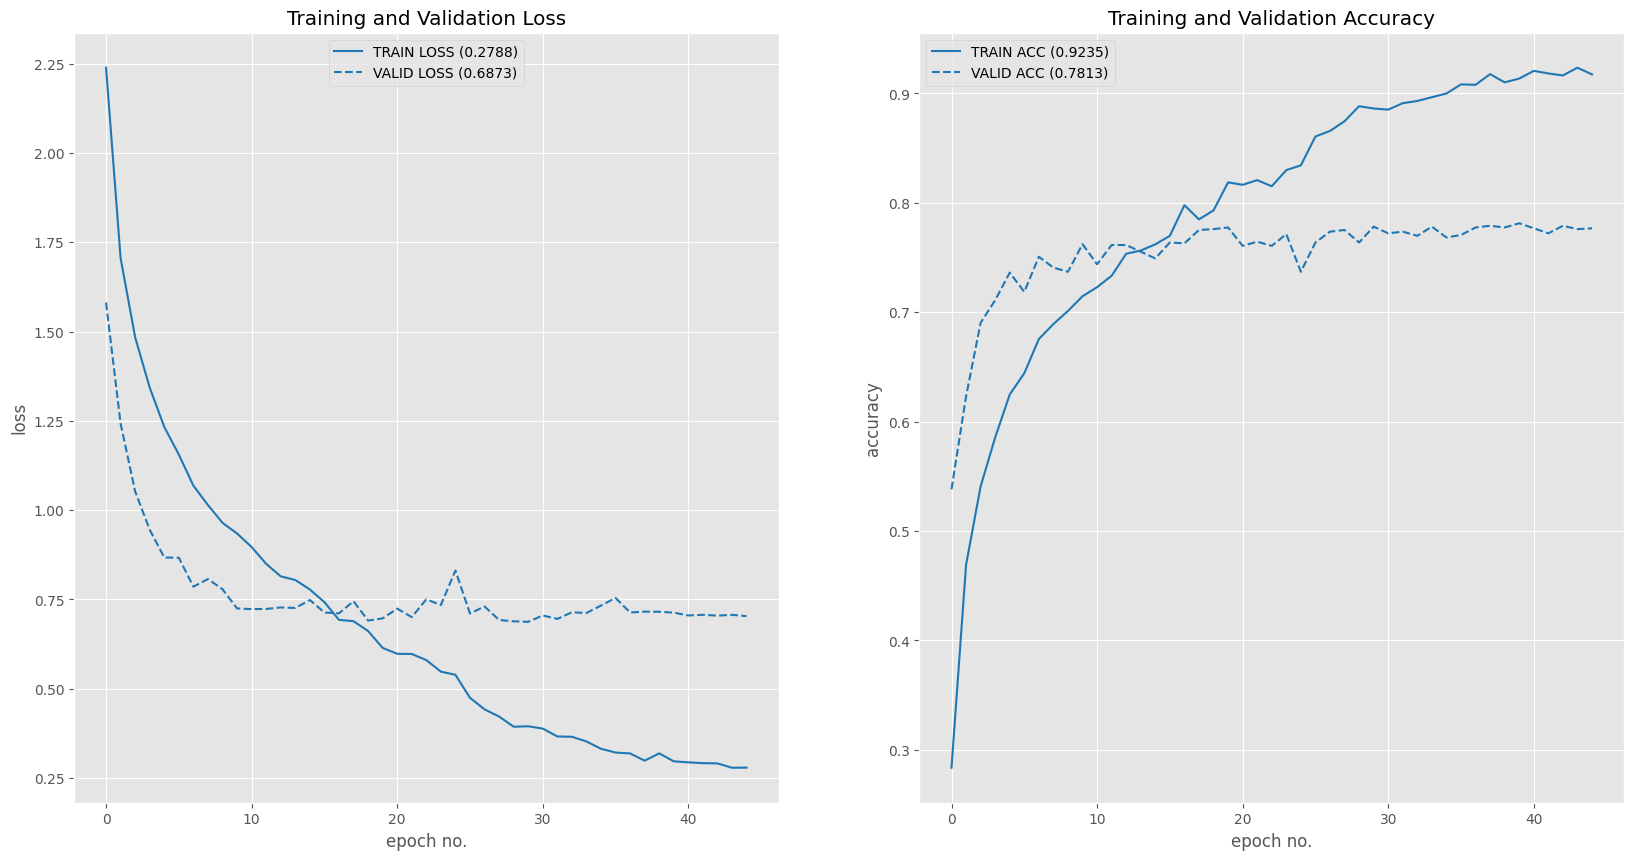

In [25]:
plot_loss_accuracy(train_loss=[train_loss], 
                   val_loss=[val_loss], 
                   train_acc=[train_acc], 
                   val_acc=[val_acc], 
                   colors=['blue'], 
                   loss_legend_loc='upper center', 
                   acc_legend_loc='upper left')

Loaded pretrained weights for efficientnet-b1
./validation


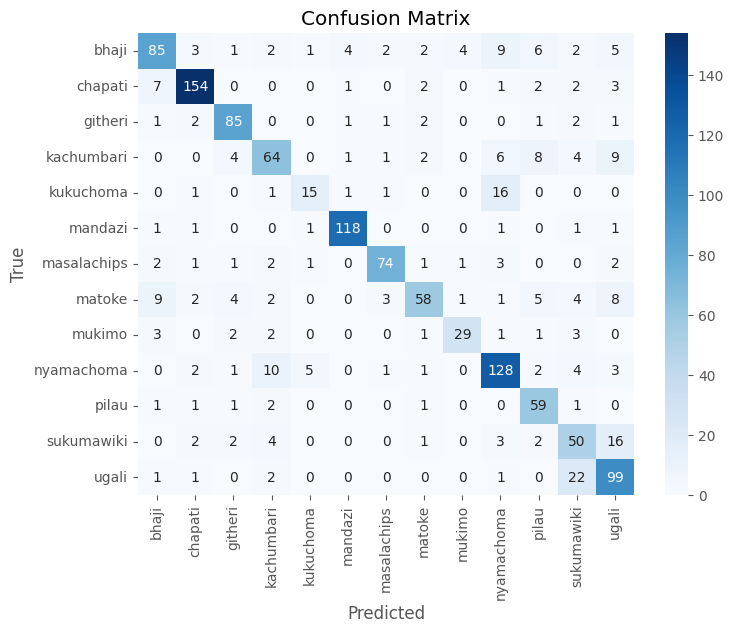

In [26]:
# m = CustomResNet()
m = CustomEfficientNet()


model = load_model(m)

train_config = TrainingConfiguration()

test_data_path = os.path.join(train_config.data_root, 'validation')
train_data_path = os.path.join(train_config.data_root, 'training')
print(test_data_path)

mean, std = get_mean_std()
plot_confusion_matrix(model, data_root=test_data_path, mean=mean, std=std)

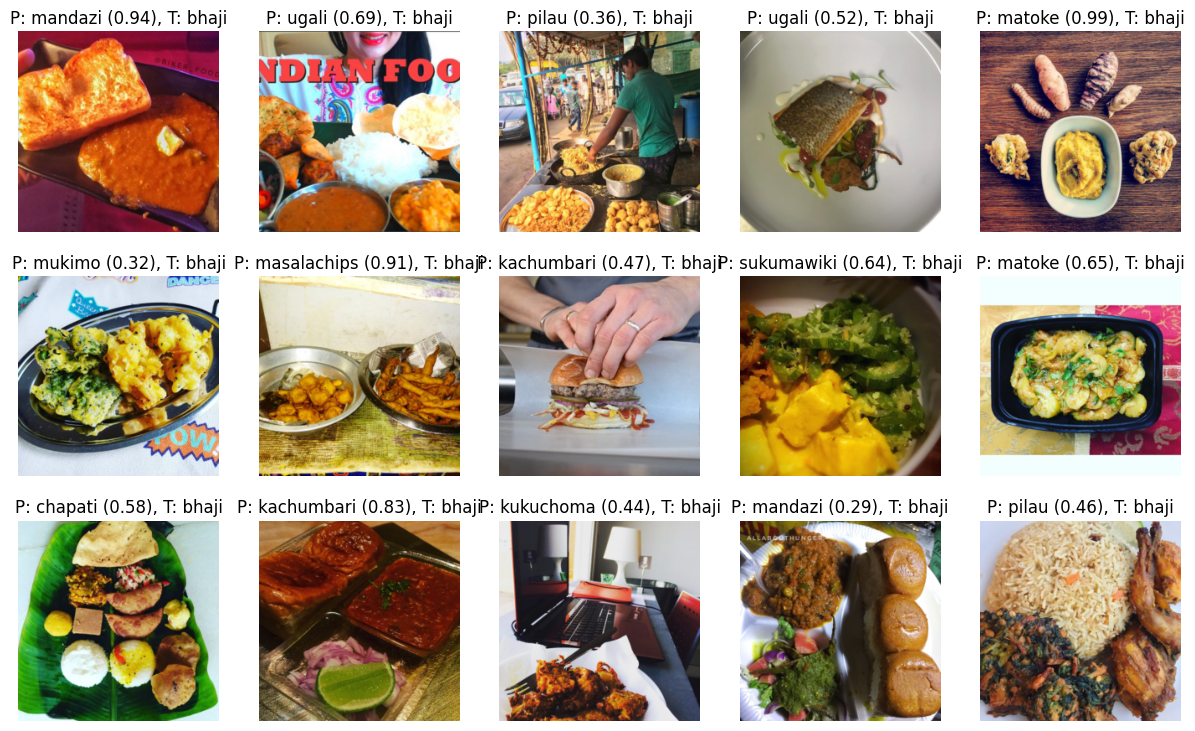

In [27]:
get_sample_mistakes(m, test_data_path, mean, std)


## <font style="color:green">8. TensorBoard Log Link [5 Points]</font>

**Share your TensorBoard scalars logs link here You can also share (not mandatory) your GitHub link, if you have pushed this project in GitHub.**


Note: In light of the recent shutdown of tensorboard.dev, we have updated the submission requirements for your project. Instead of sharing a tensorboard.dev link, you are now required to upload your generated TensorBoard event files directly onto the lab. As an alternative, you may also include a screenshot of your TensorBoard output within your Jupyter notebook. This adjustment ensures that your data visualization and model training efforts are thoroughly documented and accessible for evaluation.

You are also welcome (and encouraged) to utilize alternative logging services like wandB or comet. In such instances, you can easily make your project logs publicly accessible and share the link with others.

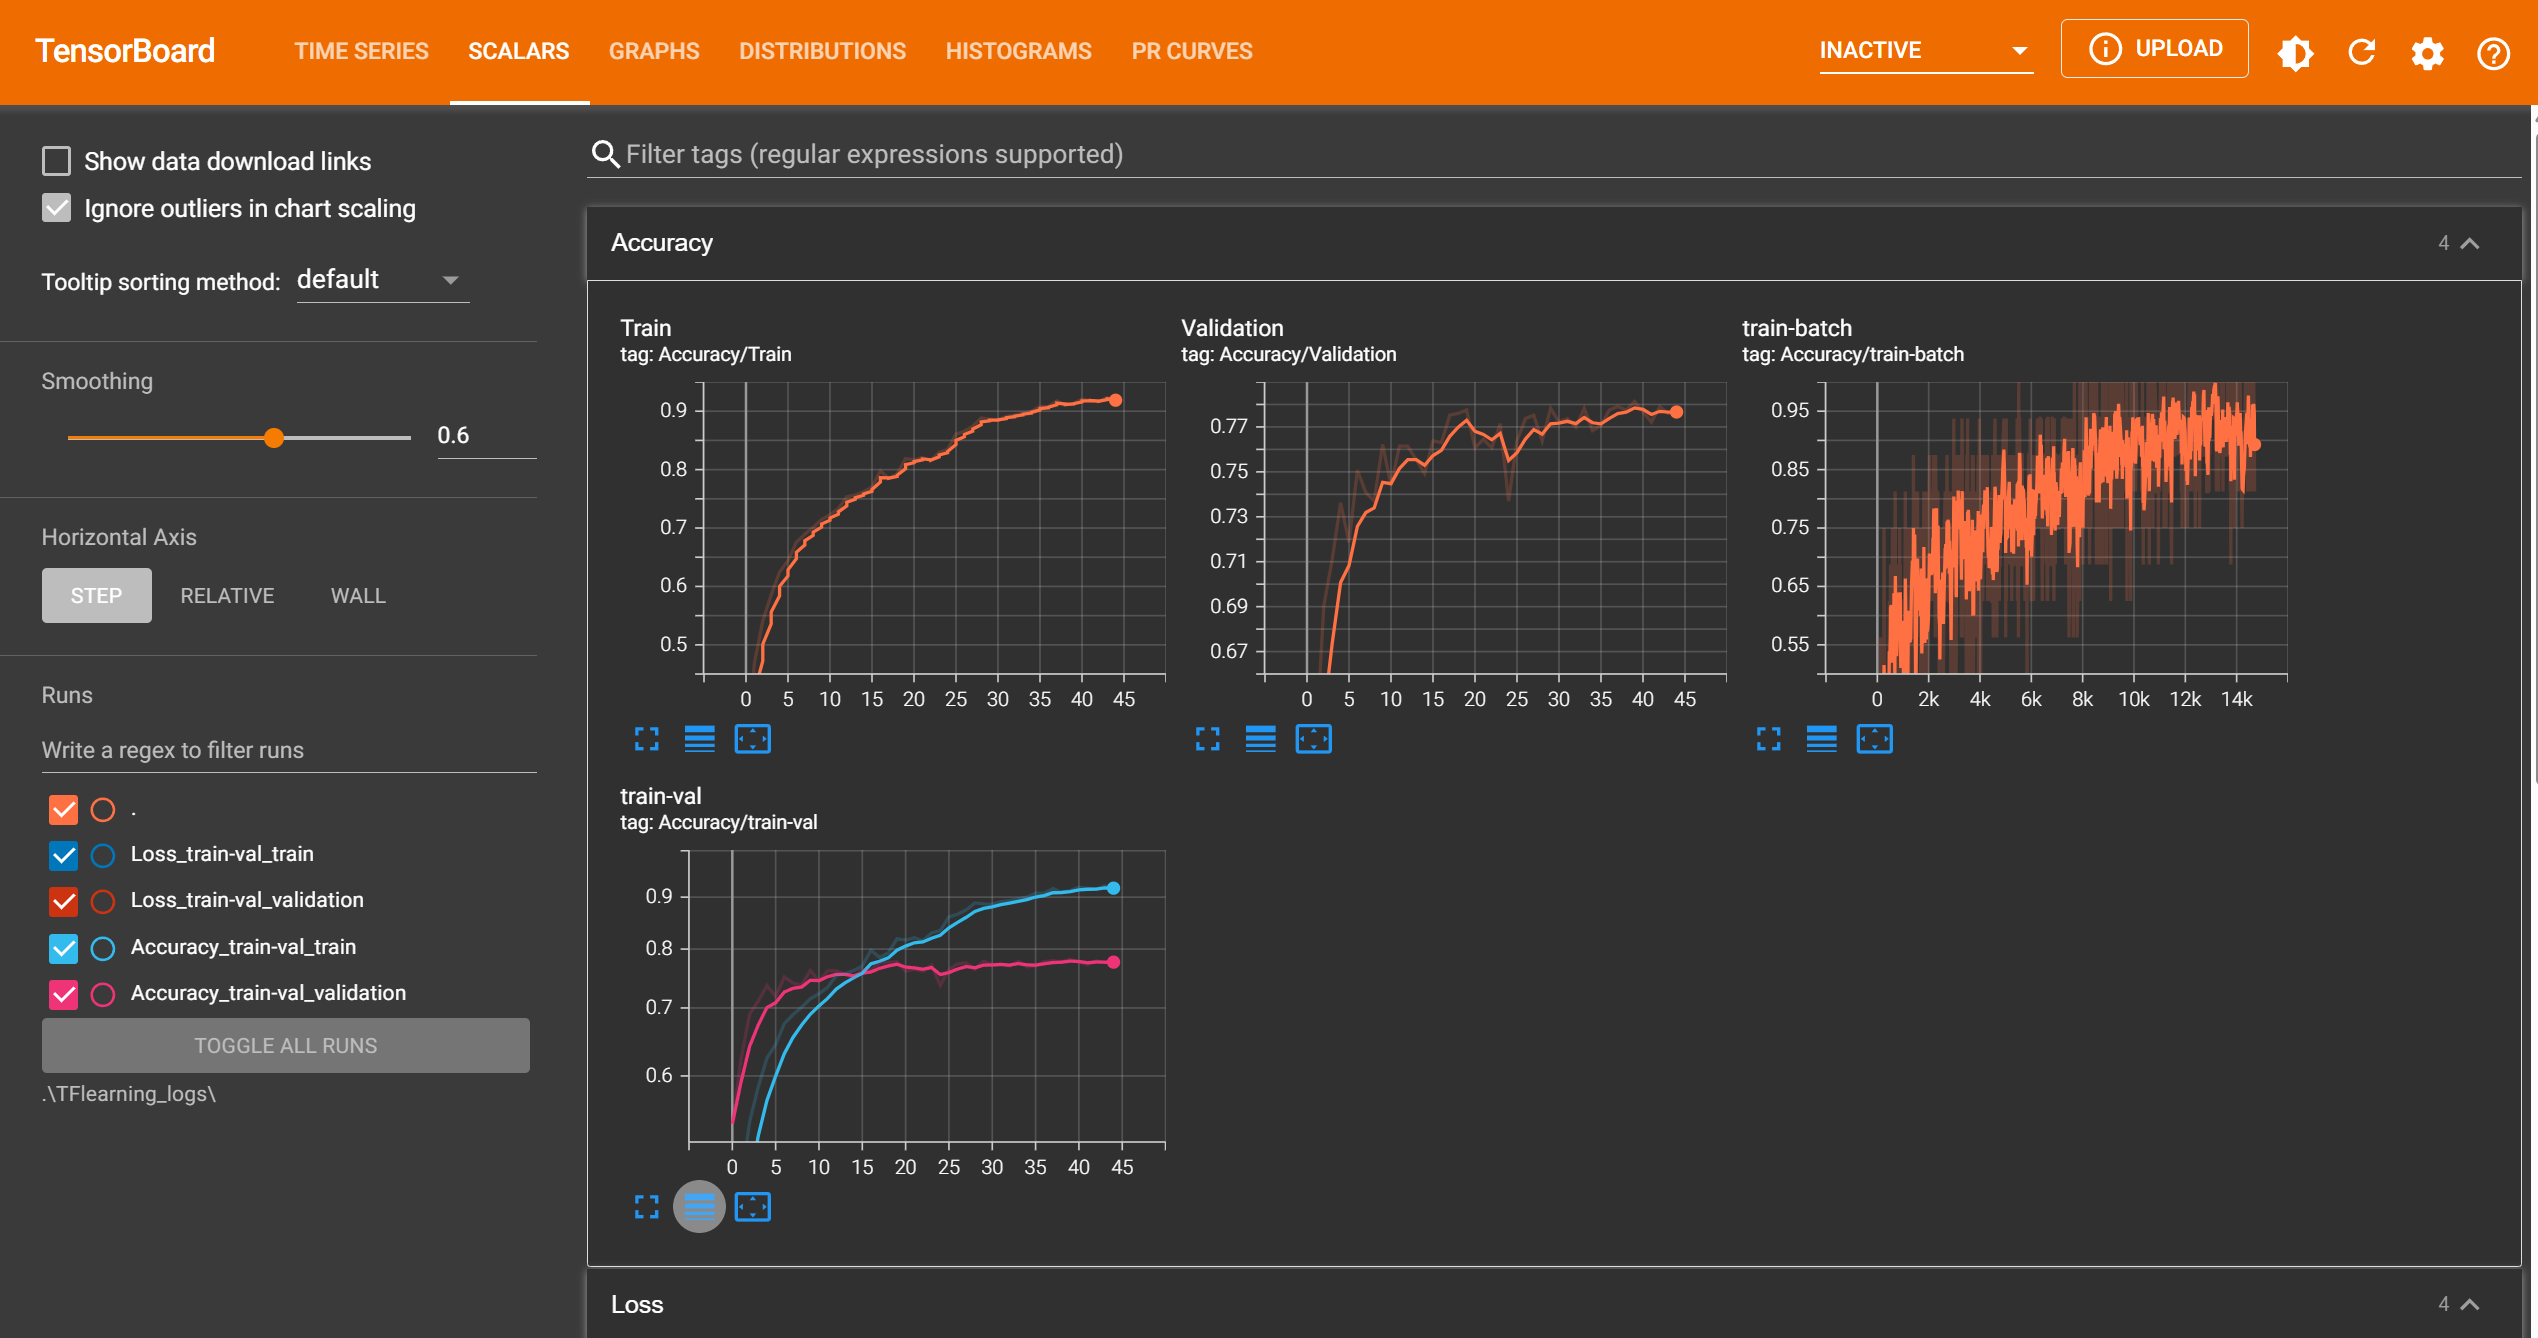

### To access the logs 
> [Google Drive Folder](https://drive.google.com/drive/folders/1dZoZ-PbAz1boPTLGJfx0PRwNNcFfMbUU?usp=sharing)

## <font style="color:green">9. Kaggle Profile Link [50 Points]</font>

**Share your Kaggle profile link  with us here to score , points in  the competition.**

**For full points, you need a minimum accuracy of `75%` on the test data. If accuracy is less than `70%`, you gain  no points for this section.**


**Submit `submission.csv` (prediction for images in `test.csv`), in the `Submit Predictions` tab in Kaggle, to get evaluated for  this section.**

Link to my [Kaggle Profile](https://www.kaggle.com/shudarshankongkham) 

In [28]:
from tqdm import tqdm

def predict_and_generate_submission(model_path, test_csv_path, images_dir, submission_csv_path, mean, std, batch_size=32):
    # Load the trained model
    device = "cuda" if torch.cuda.is_available() else "cpu"
    # model = pretrained_resnet18()  # Initialize the model architecture
    # model  = OptimizedResnet18()
    # model = CustomResNet()
    model = CustomEfficientNet()

    model = load_model(model)  # Load the state dictionary
    model.to(device)
    model.eval()
    
    # Read the test.csv file
    test_df = pd.read_csv(test_csv_path)
    
    # Define the image transformations
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Adjust the size as needed
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
    
    # Function to load and preprocess an image
    def load_image(image_id):
        image_path = os.path.join(images_dir, f"{image_id}.jpg")
        if not os.path.exists(image_path):
            raise FileNotFoundError(f"Image file not found: {image_path}")
        image = Image.open(image_path).convert("RGB")
        return transform(image)
    
    # List to store predictions
    predictions = []
    
    # Disable gradient calculation for inference
    with torch.no_grad():
        for image_id in tqdm(test_df['id'], desc="Processing images"):
            image = load_image(image_id)
            image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device
            output = model(image)
            pred = torch.argmax(output, dim=1).item()
            predictions.append(pred)
    
    # Map predictions to class names
    class_names = food_classes
    predicted_classes = [class_names[pred] for pred in predictions]
    
    # Create the submission DataFrame
    submission_df = pd.DataFrame({
        'id': test_df['id'],
        'class': predicted_classes
    })
    
    # Save the submission DataFrame to a CSV file
    submission_df.to_csv(submission_csv_path, index=False)
    print(f"Submission file saved to {submission_csv_path}")

# Example usage
model_path = 'models/final_kenyaFood_classifier.pt'
# model_path = 'checkpoint.pt'
print(model_path)
test_csv_path = 'test.csv'
images_dir = 'images/images'
submission_csv_path = 'submission.csv'
mean, std = get_mean_std()

predict_and_generate_submission(model_path, test_csv_path, images_dir, submission_csv_path, mean, std)

models/final_kenyaFood_classifier.pt
Loaded pretrained weights for efficientnet-b1


Processing images: 100%|██████████| 1638/1638 [01:13<00:00, 22.39it/s]

Submission file saved to submission.csv


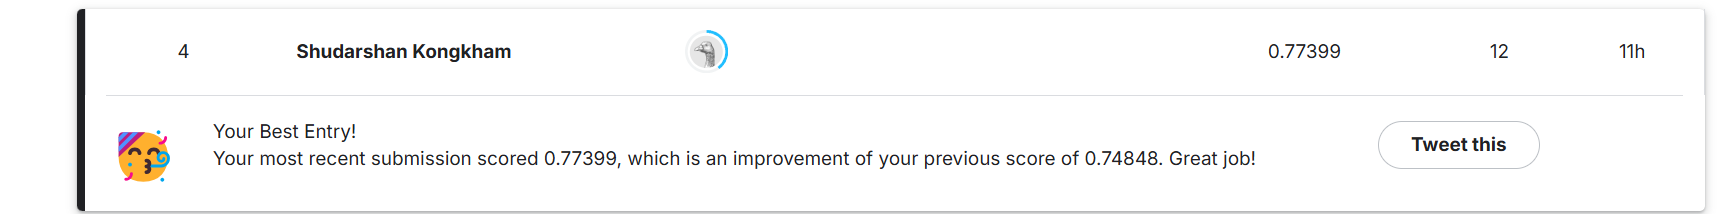

# Reflection: Building a Kenyan Food Image Classifier - A Journey of Iterative Improvement

This project aimed to build an image classifier capable of accurately identifying different types of Kenyan food dishes.  It was an insightful journey, filled with challenges and valuable learnings as we iteratively refined the model to improve its performance.

## Initial Steps and Baseline

We started by establishing a baseline using a **ResNet50** architecture pre-trained on ImageNet.  This transfer learning approach was chosen to leverage the rich feature representations learned by ResNet50 from a large dataset.  Our initial training configuration included:

*   **ResNet50 (pretrained=True):** As the base model.
*   **Custom Classifier Head:** Replaced ResNet50's final fully connected layer to suit our 13 Kenyan food classes.
*   **Adam Optimizer:** A robust and commonly used optimizer.
*   **Initial Learning Rate: 0.01:**  A starting point for learning rate, although potentially aggressive for transfer learning.
*   **Basic Data Augmentation:** Simple transformations like resizing, center cropping, and normalization using ImageNet statistics.

However, the initial training results were disheartening. The **validation accuracy was stuck at a very low level (around 6-13%)**, and the **loss remained high and stagnant**. This indicated a fundamental problem preventing the model from learning.

## Identifying and Addressing the Bottleneck: Data Preprocessing

Our first crucial realization was that **data preprocessing was the primary bottleneck**.  Through careful analysis and visualization (using a corrected `imshow` function), we identified:

*   **Incorrect Normalization:** The initial normalization was not correctly applying ImageNet statistics. This was a critical error, as pre-trained models are highly sensitive to the input data distribution.
*   **Lack of Validation Data Visualization:**  We started visualizing batches of training and validation data *after* preprocessing. This visual inspection was key to confirming that the data was being loaded and transformed correctly.

By correcting the normalization to use the **exact ImageNet mean and standard deviation** in both training and validation transformations, we saw an **immediate and significant improvement**. The model started learning, and validation accuracy began to increase.

## Tackling Overfitting and Boosting Validation Accuracy

As training progressed, we observed a classic **overfitting pattern**:

*   **Training loss decreased significantly, and training accuracy reached high levels.**
*   **Validation loss plateaued and started to diverge from training loss.**
*   **Validation accuracy plateaued around 72-76%, lagging behind training accuracy.**

To combat overfitting and further improve validation accuracy, we iteratively employed several strategies:

**1. Regularization Techniques:**

*   **Dropout and Batch Normalization:** We **uncommented Dropout and Batch Normalization layers** in the custom classifier head of both ResNet50 and EfficientNet. These layers acted as crucial regularizers, preventing the model from becoming too specialized to the training data and improving generalization.
*   **Weight Decay (L2 Regularization):** We added **weight decay (0.0001)** to the Adam optimizer. This penalized large weights, encouraging the model to learn simpler and more generalizable representations.
*   **Experimented with Dropout Probability:**  We tried increasing the dropout probability slightly to enhance regularization.

**2. Enhanced Data Augmentation:**

*   **More Aggressive Augmentations:** We increased the intensity of existing augmentations like `RandomRotation`, `ColorJitter`, and `RandomAffine` within our `data_augmentation_preprocess` pipeline. This exposed the model to more diverse variations of the Kenyan food images.
*   **Implemented CutMix:** We integrated **CutMix augmentation** into the training loop. CutMix proved to be a powerful technique for improving generalization. By mixing patches of images and their labels within a batch, it forced the model to learn more robust features and rely less on spurious correlations.

**3. Model Architecture Exploration:**

*   **Transition to EfficientNet-B0:**  Recognizing EfficientNet's superior efficiency and performance in image classification, we **switched from ResNet50 to EfficientNet-B0**. This change yielded noticeable improvements in validation accuracy and training efficiency. EfficientNet's compound scaling and MBConv blocks proved to be more effective for our task.
*   **Consideration of Larger EfficientNet Variants:** We considered experimenting with larger EfficientNet variants (like B1 or B2) if further accuracy gains were needed, but focused on regularization and augmentation first.

**4. Learning Rate Scheduling Fine-tuning:**

*   **Lower Initial Learning Rate:** We reduced the initial learning rate (e.g., to 0.0001) to prevent disrupting the pre-trained weights and facilitate finer tuning.
*   **Adjusted LR Scheduler Factor:** We experimented with the `factor` in `ReduceLROnPlateau`, trying a less aggressive reduction (e.g., 0.5) to allow for more gradual learning rate decay.

## Performance Improvements and Final Outcome

Through this iterative process of debugging, analyzing, and implementing various improvement strategies, we saw a significant jump in validation accuracy. By using **EfficientNet-B0, stronger data augmentations (including CutMix), and regularization (Dropout, BatchNorm, Weight Decay),** we achieved a **validation accuracy around 76%**.  While we aimed for 85%+ initially, reaching 76% represents a substantial improvement over the baseline and showcases the effectiveness of these techniques.

The training curves reflected a much healthier training process:

*   **Training and validation losses converged more closely.**
*   **The overfitting gap narrowed significantly.**
*   **Validation accuracy reached a more respectable level.**

## Key Learnings and Takeaways

This journey of building the Kenyan food image classifier provided valuable insights into deep learning model development and performance optimization:

*   **Data Preprocessing is Paramount:**  Correct data loading and preprocessing, especially normalization for pre-trained models, are absolutely essential for success. Even minor errors can severely hinder learning.
*   **Visualization is Crucial for Debugging:** Visualizing data, model architecture, and training progress is invaluable for identifying issues and understanding model behavior.
*   **Iterative Improvement is Key:**  Deep learning model development is rarely a linear process. It's an iterative cycle of:
    *   **Baseline Establishment:** Start with a reasonable architecture and configuration.
    *   **Performance Analysis:** Analyze training curves and metrics to identify bottlenecks (overfitting, underfitting, etc.).
    *   **Hypothesis and Strategy:** Formulate hypotheses about how to improve performance (e.g., more regularization, stronger augmentation).
    *   **Implementation and Experimentation:** Implement the chosen strategy and run experiments.
    *   **Evaluation:**  Assess the results, and repeat the cycle.
*   **Transfer Learning Power:** Leveraging pre-trained models like ResNet and EfficientNet significantly accelerates development and improves performance, especially when dealing with limited datasets.
*   **Regularization and Augmentation for Generalization:**  Regularization techniques and data augmentation are crucial for preventing overfitting and improving a model's ability to generalize to unseen data.
*   **Model Architecture Matters:** EfficientNet's architecture, designed for efficiency and performance, proved to be a better choice for our task compared to ResNet50, highlighting the importance of architecture selection.

While further improvements might be possible (e.g., exploring larger EfficientNet variants, even more aggressive augmentations, or dataset expansion), this project provided a comprehensive learning experience in building, debugging, and iteratively optimizing an image classifier using modern deep learning techniques. It underscored the importance of a systematic approach, data understanding, and continuous experimentation for achieving desired performance in deep learning projects.

---